### Anomaly Detection: AutoEncoder con PyOD

con PyOD posso realizzare un modello usando AutoEncoder senza conoscere TF e Keras.
Ovviamente i risultati sono gli stessi del primo modello.

* L.S.: 07/2021
* modified 4/10/2021

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed

import tensorflow as tf

# PyOD
from pyod.models.auto_encoder import AutoEncoder

sns.set(color_codes=True)
%matplotlib inline

In [2]:
# globals
SEED = 4321

# to make it more deterministic
seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# globals
FIGSIZE = (12,8)

# some utilities functions
def extract_date(x):
    return str(pd.to_datetime(x).date())

# visualize loss for the training (avoid first epochs to see improvements)
def plot_loss(history, start_from=0):
    plt.figure(figsize = FIGSIZE)
    
    hist_loss = history['loss']
    hist_val_loss = history['val_loss']
    vet_epochs = range(start_from, len(hist_val_loss))
    
    plt.plot(vet_epochs, hist_loss[start_from:],'b', label='Training loss')
    plt.plot(vet_epochs, hist_val_loss[start_from:],'r', label='Validation loss')

    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (mse)')

    plt.show()

def compute_and_plot_anomalies(score, title):
    # extract day
    score['Day'] = score.index
    score['Day'] = score['Day'].apply(extract_date)

    vet_x = score.groupby(['Day']).sum().index
    vet_y = score.groupby(['Day']).sum()['Anomaly']

    plt.figure(figsize=FIGSIZE)
    plt.title(title)
    sns.barplot(x=vet_x, y=vet_y)

    plt.xticks(rotation=90)
    plt.grid(True)
    
    return vet_x, vet_y

In [4]:
FILE_NAME = "BearingsNasaTest1.csv"

result_data = pd.read_csv(FILE_NAME, index_col = 0)

# attenzione al formato della data
result_data.index = pd.to_datetime(result_data.index, format='%Y-%m-%d %H:%M:%S')
result_data = result_data.sort_index()

In [5]:
result_data.head()

,Br11,Br12,Br21,Br22,Br31,Br32,Br41,Br42
2003-10-22 12:06:24,0.1041,0.1003,0.1071,0.1020,0.1061,0.1082,0.0948,0.0995
2003-10-22 12:09:13,0.1037,0.0999,0.1082,0.1029,0.1067,0.1085,0.0951,0.0936
2003-10-22 12:14:13,0.1050,0.1015,0.1085,0.1040,0.1087,0.1099,0.0962,0.0983
2003-10-22 12:19:13,0.1049,0.1016,0.1082,0.1034,0.1081,0.1100,0.0968,0.0986
2003-10-22 12:24:13,0.1048,0.1022,0.1079,0.1026,0.1085,0.1093,0.0964,0.0985


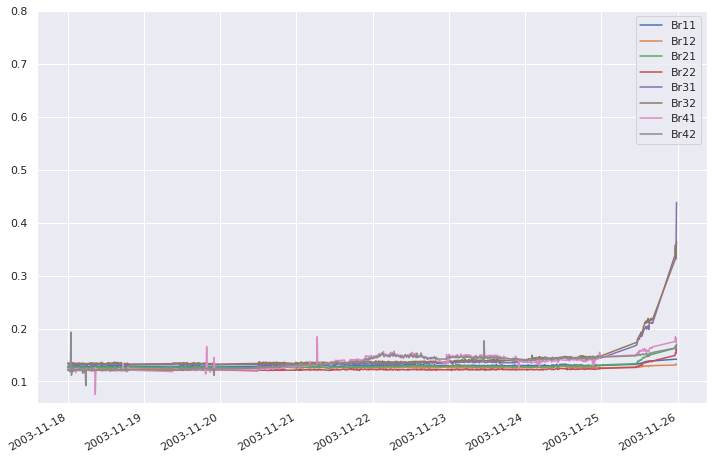

In [6]:
# train/test split

# data from the first interval used for training
START_TIME = '2003-10-25 00:00:01'
SPLIT_TIME = '2003-11-17 23:59:00'

# before the SPLIT_TIME
dataset_train = result_data[START_TIME:SPLIT_TIME]

dataset_test = result_data[SPLIT_TIME:]

# let's see the last part
dataset_test.plot(figsize = FIGSIZE, ylim = (0.06, 0.8));

In [7]:
# porto le feature sulla stessa scala...
# with PyOD the clf can do scaling... se below
X_train = dataset_train
X_test = dataset_test

In [8]:
# with PyOD we don't need to code the NN, only use a Python class
clf1 = AutoEncoder(hidden_neurons =[6, 4, 2, 4, 6], output_activation=None, 
                   contamination=0.01, dropout_rate=0, random_state=SEED, 
                   # can do preprocessing
                   preprocessing=True,
                   verbose=0, epochs=120)

In [9]:
%%time

clf1.fit(np.array(X_train))

CPU times: user 28.9 s, sys: 4.75 s, total: 33.7 s
Wall time: 19.7 s


AutoEncoder(batch_size=32, contamination=0.01, dropout_rate=0, epochs=120,
      hidden_activation='relu', hidden_neurons=[6, 4, 2, 4, 6],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f5c03a86560>,
      optimizer='adam', output_activation=None, preprocessing=True,
      random_state=4321, validation_size=0.1, verbose=0)

In [10]:
history = clf1.history_

# plot_loss(history, start_from=10)

In [11]:
# Get the outlier scores

# train
od_train_scores = clf1.decision_function(np.array(X_train))  
od_train_scores = pd.DataFrame(od_train_scores, index = X_train.index, columns = ['OUTSCORE'])

# Predict the anomaly scores on test data
od_test_scores = clf1.decision_function(np.array(X_test))  # outlier scores
od_test_scores = pd.DataFrame(od_test_scores, index = X_test.index, columns = ['OUTSCORE'])

/home/datascience/conda/tensorflow23_p37_gpu_v1/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 100.0)

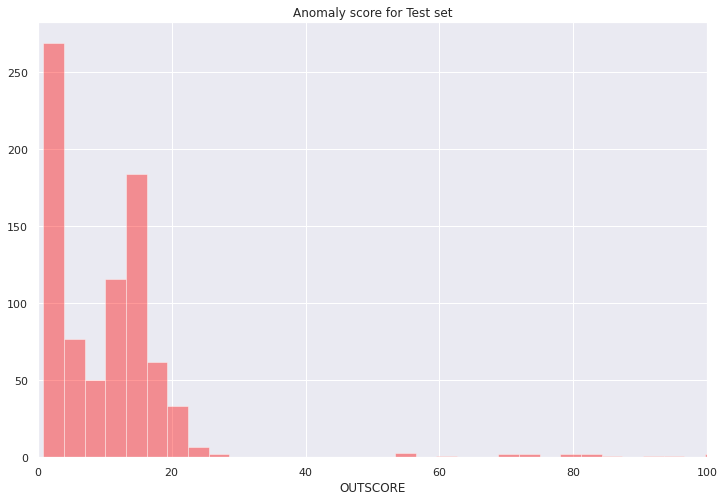

In [12]:
# disegno istogramma
plt.figure(figsize = (12,8))
plt.title('Anomaly score for Test set')
sns.distplot(od_test_scores['OUTSCORE'], bins = 128, kde= False, color = 'red');
plt.xlim([0.0,100])

/home/datascience/conda/tensorflow23_p37_gpu_v1/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


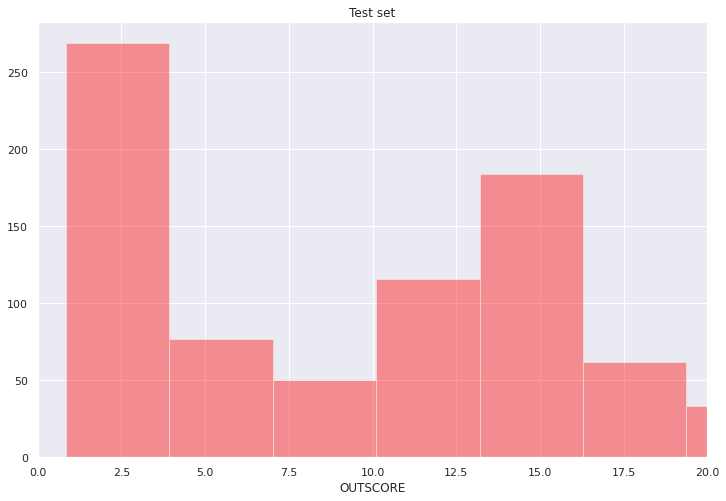

In [13]:
# zoom sulla prima parte
plt.figure(figsize = (12,8))
plt.title('Test set')
plt.xlim((0, 20))
sns.distplot(od_test_scores['OUTSCORE'], bins = 128, kde=False, color = 'red');

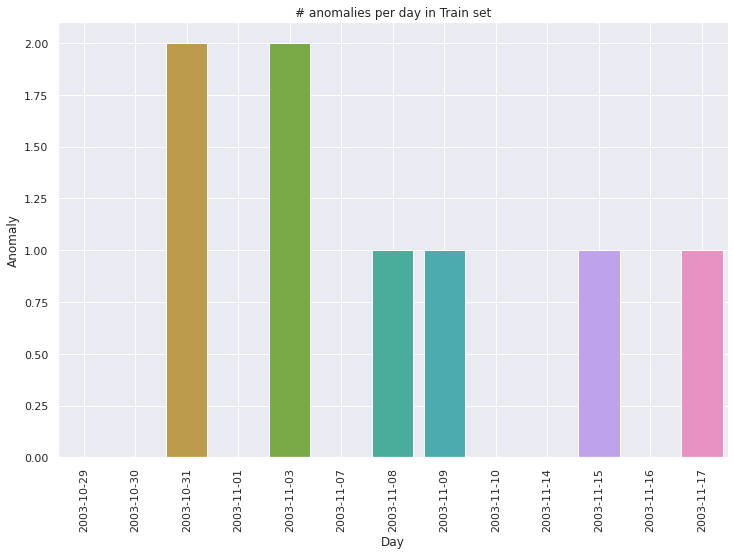

In [14]:
# If we choose a THR what is the percentage of anomalies in the training set?
THR = 8

od_train_scores['Threshold'] = THR
od_train_scores['Anomaly'] = od_train_scores['OUTSCORE'] > od_train_scores['Threshold']

vet_x, vet_y = compute_and_plot_anomalies(od_train_scores, '# anomalies per day in Train set')

In [15]:
# count the number and compute percentage
score = od_train_scores

print('Train dataset # of points:', score.shape[0])

num_anom = np.sum(vet_y)
perc_anom = round(num_anom*100./score.shape[0], 2)

print()
print('Train dataset: # of ANOM points:', num_anom)
print('Train dataset: % of ANOM points:', perc_anom, '%')

Train dataset # of points: 1163

Train dataset: # of ANOM points: 8
Train dataset: % of ANOM points: 0.69 %


In [16]:
# compute on test set

od_test_scores['Threshold'] = THR
od_test_scores['Anomaly'] = od_test_scores['OUTSCORE'] > od_test_scores['Threshold']

In [17]:
od_test_scores.tail()

,OUTSCORE,Threshold,Anomaly
2003-11-25 16:07:32,122.159964,8,True
2003-11-25 23:13:21,291.588590,8,True
2003-11-25 23:19:56,320.909768,8,True
2003-11-25 23:29:56,286.243408,8,True
2003-11-25 23:39:56,396.159942,8,True


/home/datascience/conda/tensorflow23_p37_gpu_v1/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:503: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


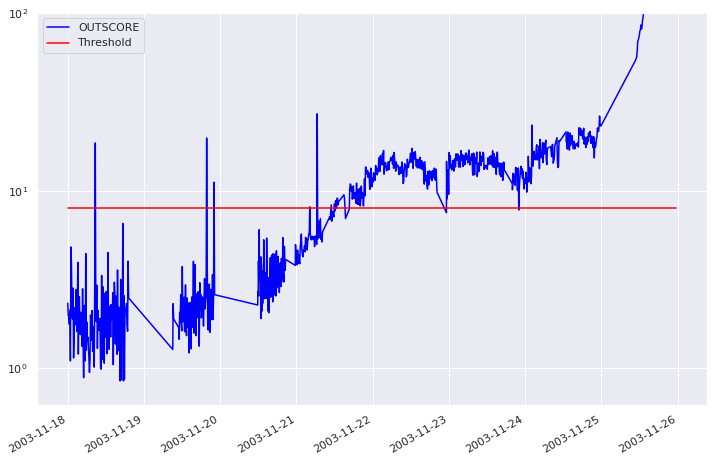

In [19]:
od_test_scores.plot(logy=True,  figsize = FIGSIZE, ylim = [0, 100], color = ['blue','red']);

### How many alerts per day in the test set?

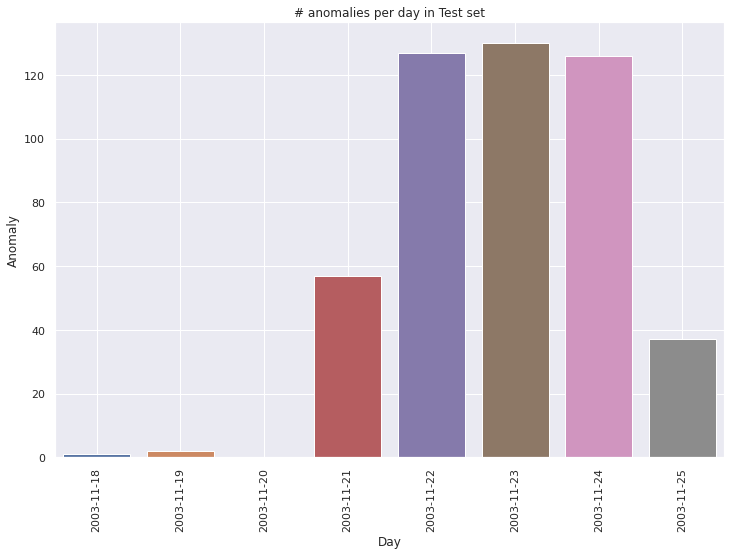

In [20]:
# count how many anomaly alerts (RE > THR) we have per day
# group by by day and sum(Anomaly)
# score = od_test_scores
    
vet_x, vet_y = compute_and_plot_anomalies(od_test_scores, '# anomalies per day in Test set')

The result is similar to what we have obtained using directly Keras. Differencies can be explained because with PyOD we're not controlling all the parameres so... there are differencies.
But we have written less code, and still able to predict with 4 days in advance

In [21]:
# have a look at the Encoder structure:

clf1.model_.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 54        
_________________________________________________________________
dropout_2 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2

In [22]:
# the suggested threshold
clf1.threshold_

6.653442608345087